##Importing dependencies

In [0]:
%matplotlib inline
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU

### We are using mnist fashion dataset

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

## The Generator


In [0]:
def build_generator():
    #Initializing a neural network
    generator = Sequential()
    
    #Adding an Input layer to the network
    generator.add(Dense(units=256,input_dim=100))    

    #Activating the layer with LeakyReLU activation function
    generator.add(LeakyReLU(0.2))

    #Applying Batch Normalization 
    generator.add(BatchNormalization(momentum=0.8))

    #Adding a second layer	
    generator.add(Dense(units=512))
    
    #Adding a third layer	
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    #The output layer with 784(28x28) nodes
    generator.add(Dense(units=784, activation='tanh'))
    
    #Compiling the Generator Network with loss and optimizer functions
    generator.compile(loss='binary_crossentropy', optimizer= keras.optimizers.adam(lr=0.0002, beta_1=0.5))
    
    return generator

## The Discriminator

In [0]:
def build_discriminator():
    #Initializing a neural network
    discriminator=Sequential()
    
    #Adding an Input layer to the network
    discriminator.add(Dense(units=1024, input_dim=784))
    
    #Activating the layer with LeakyReLU activation function
    discriminator.add(LeakyReLU(0.2))
    
    #Adding a dropout layer to reduce overfitting
    discriminator.add(Dropout(0.2))
       
    #Adding a second layer
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    #Adding a third layer	 
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    #Adding a forth layer
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #Adding the output layer with sigmoid activation
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #Compiling the Discriminator Network with loss and optimizer functions
    discriminator.compile(loss='binary_crossentropy', optimizer = keras.optimizers.adam(lr=0.0002, beta_1=0.5))
    
    return discriminator

In [0]:
def gan_net(generator, discriminator):
  
    #Setting the trainable parameter of discriminator to False
    discriminator.trainable=False
    
    #Instantiates a Keras tensor of shape 100 (Noise shape)
    inp = Input(shape=(100,))
    
    #Feeds the input noise to the generator and stores the output in X
    X = generator(inp)
    
    #Feeds the output from generator(X) to the discriminator and stores the result in out
    out= discriminator(X)
    
    #Creates a model include all layers required in the computation of out given inp.
    gan= Model(inputs=inp, outputs=out)
    
    #Compiling the GAN Network
    gan.compile(loss='binary_crossentropy', optimizer = 'adam')
    
    return gan

In [0]:
def plot_images(epoch, generator, dim = (10,10), figsize=(10,10)):     
    noise= np.random.normal(loc=0, scale=1, size=[100, 100]) 
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i],cmap='gray', interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

In [0]:
def train(X_train, epochs=5, batch_size=128):
    
    
    #Initializing the GAN 
    generator= build_generator()
    discriminator= build_discriminator()
    gan = gan_net(generator,discriminator)
    
    
    # Training the model for specified epochs
    
    for e in range(1,epochs+1 ):
        print("###### @ Epoch ", e)
        
        for _ in tqdm(range(batch_size)):
          
            #Random noise with size batch_sizex100
            noise= np.random.normal(0,1, [batch_size, 100])
            
            #Generating images from noise
            generated_images = generator.predict(noise)
            
            #taking random images from the training set 
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Creating a new training set with real and fake images 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)  
            y_dis[:batch_size]=1.0 # label for real images
            
            #Training the discriminator with real and generated images
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Labelling the generated images a sreal images(1) to trick the discriminator
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            #Freezing the weights of the discriminator while training generator
            discriminator.trainable=False
            
            #Training the gan network
            gan.train_on_batch(noise, y_gen)
        
        #Plotting the images for every 10 epochs
        if e == 1 or e % 10 == 0:
          plot_images(e,generator,dim = (10,10) , figsize=(15,15))

In [0]:
#Unpacking the training data from mnist data dataset
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#Converting to float type and normalizing the data
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# convert shape of X_train from (60000, 28, 28) to (60000, 784) - 784 columns per row
X_train = X_train.reshape(60000, 784)

  0%|          | 0/100 [00:00<?, ?it/s]

###### @ Epoch  1


  5%|▌         | 5/100 [00:00<00:02, 46.60it/s]

###### @ Epoch  2


  6%|▌         | 6/100 [00:00<00:01, 58.48it/s]

###### @ Epoch  3


  6%|▌         | 6/100 [00:00<00:01, 59.57it/s]

###### @ Epoch  4


  6%|▌         | 6/100 [00:00<00:01, 55.53it/s]

###### @ Epoch  5


  6%|▌         | 6/100 [00:00<00:01, 59.65it/s]

###### @ Epoch  6


  6%|▌         | 6/100 [00:00<00:01, 56.12it/s]

###### @ Epoch  7


  6%|▌         | 6/100 [00:00<00:01, 57.37it/s]

###### @ Epoch  8


  6%|▌         | 6/100 [00:00<00:01, 59.75it/s]

###### @ Epoch  9


  7%|▋         | 7/100 [00:00<00:01, 61.25it/s]

###### @ Epoch  10


  5%|▌         | 5/100 [00:00<00:02, 44.06it/s]

###### @ Epoch  11


  6%|▌         | 6/100 [00:00<00:01, 59.71it/s]

###### @ Epoch  12


  6%|▌         | 6/100 [00:00<00:01, 56.97it/s]

###### @ Epoch  13


  7%|▋         | 7/100 [00:00<00:01, 60.26it/s]

###### @ Epoch  14


  7%|▋         | 7/100 [00:00<00:01, 60.38it/s]

###### @ Epoch  15


  7%|▋         | 7/100 [00:00<00:01, 61.04it/s]

###### @ Epoch  16


  6%|▌         | 6/100 [00:00<00:01, 55.49it/s]

###### @ Epoch  17


  7%|▋         | 7/100 [00:00<00:01, 62.40it/s]

###### @ Epoch  18


  6%|▌         | 6/100 [00:00<00:01, 58.95it/s]

###### @ Epoch  19


  6%|▌         | 6/100 [00:00<00:01, 59.48it/s]

###### @ Epoch  20


  6%|▌         | 6/100 [00:00<00:01, 52.46it/s]

###### @ Epoch  21


  6%|▌         | 6/100 [00:00<00:01, 58.99it/s]

###### @ Epoch  22


  6%|▌         | 6/100 [00:00<00:01, 55.47it/s]

###### @ Epoch  23


  7%|▋         | 7/100 [00:00<00:01, 60.51it/s]

###### @ Epoch  24


  7%|▋         | 7/100 [00:00<00:01, 58.60it/s]

###### @ Epoch  25


  6%|▌         | 6/100 [00:00<00:01, 56.45it/s]

###### @ Epoch  26


  7%|▋         | 7/100 [00:00<00:01, 60.21it/s]

###### @ Epoch  27


  7%|▋         | 7/100 [00:00<00:01, 62.69it/s]

###### @ Epoch  28


  7%|▋         | 7/100 [00:00<00:01, 62.37it/s]

###### @ Epoch  29


  7%|▋         | 7/100 [00:00<00:01, 60.96it/s]

###### @ Epoch  30


  5%|▌         | 5/100 [00:00<00:02, 46.68it/s]

###### @ Epoch  31


  7%|▋         | 7/100 [00:00<00:01, 61.71it/s]

###### @ Epoch  32


  7%|▋         | 7/100 [00:00<00:01, 61.94it/s]

###### @ Epoch  33


  6%|▌         | 6/100 [00:00<00:01, 58.14it/s]

###### @ Epoch  34


  7%|▋         | 7/100 [00:00<00:01, 59.98it/s]

###### @ Epoch  35


  7%|▋         | 7/100 [00:00<00:01, 61.72it/s]

###### @ Epoch  36


  7%|▋         | 7/100 [00:00<00:01, 62.03it/s]

###### @ Epoch  37


  7%|▋         | 7/100 [00:00<00:01, 63.69it/s]

###### @ Epoch  38


  7%|▋         | 7/100 [00:00<00:01, 59.19it/s]

###### @ Epoch  39


  7%|▋         | 7/100 [00:00<00:01, 63.19it/s]

###### @ Epoch  40


  6%|▌         | 6/100 [00:00<00:01, 52.11it/s]

###### @ Epoch  41


  6%|▌         | 6/100 [00:00<00:01, 54.59it/s]

###### @ Epoch  42


  7%|▋         | 7/100 [00:00<00:01, 60.91it/s]

###### @ Epoch  43


  6%|▌         | 6/100 [00:00<00:01, 58.44it/s]

###### @ Epoch  44


  7%|▋         | 7/100 [00:00<00:01, 61.81it/s]

###### @ Epoch  45


  7%|▋         | 7/100 [00:00<00:01, 60.16it/s]

###### @ Epoch  46


  7%|▋         | 7/100 [00:00<00:01, 63.81it/s]

###### @ Epoch  47


  6%|▌         | 6/100 [00:00<00:01, 58.39it/s]

###### @ Epoch  48


  6%|▌         | 6/100 [00:00<00:01, 54.77it/s]

###### @ Epoch  49


  6%|▌         | 6/100 [00:00<00:01, 57.58it/s]

###### @ Epoch  50


100%|██████████| 100/100 [00:01<00:00, 59.55it/s]


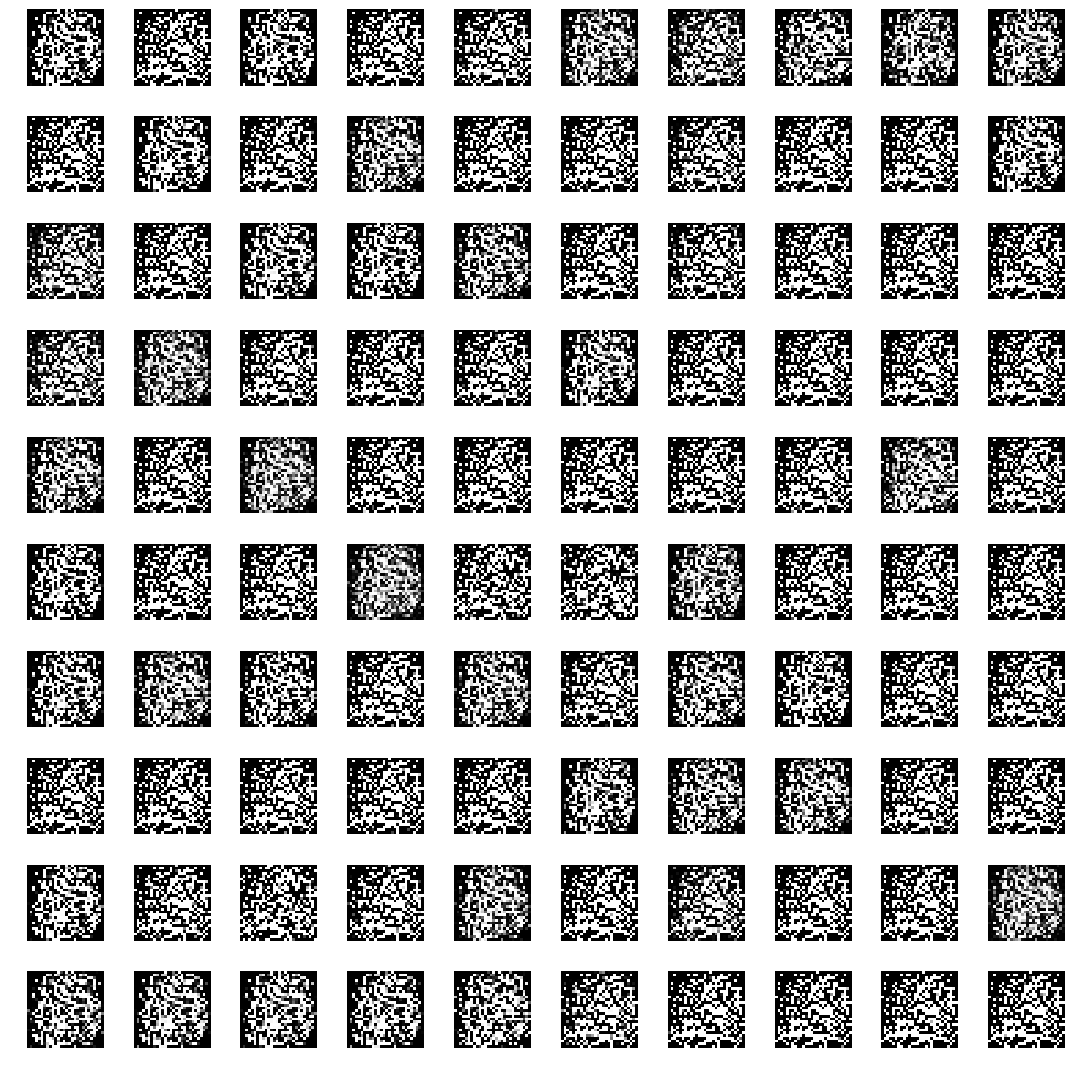

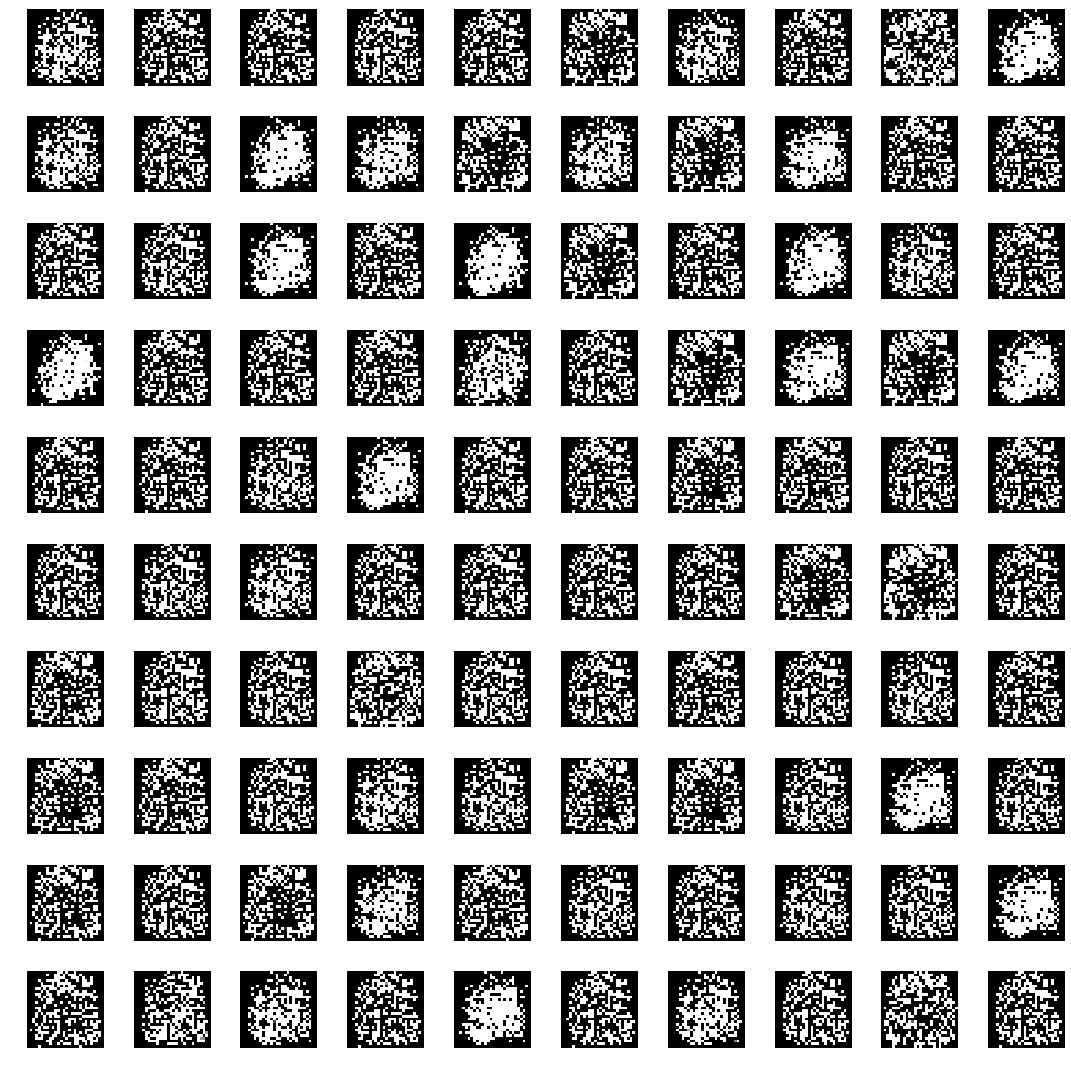

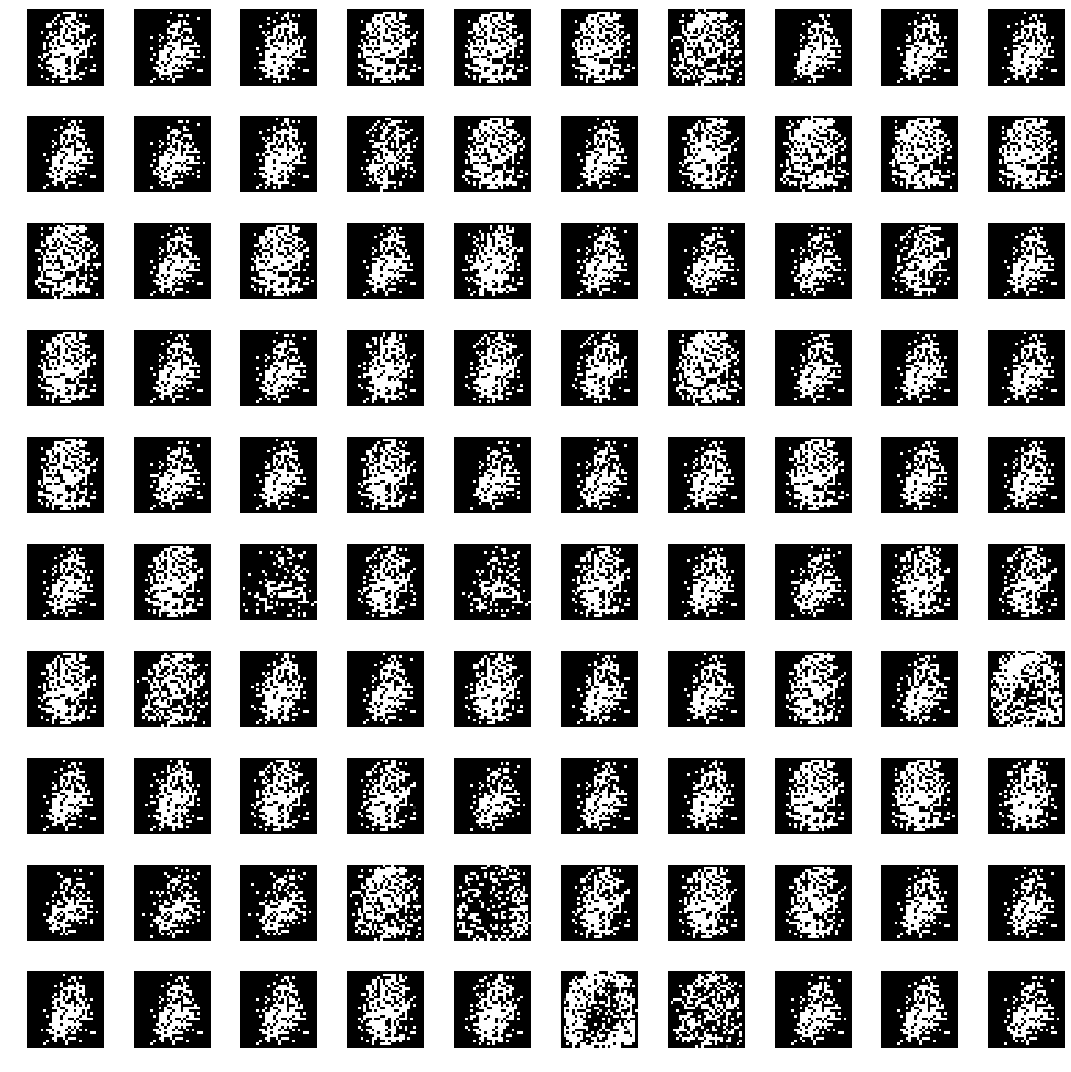

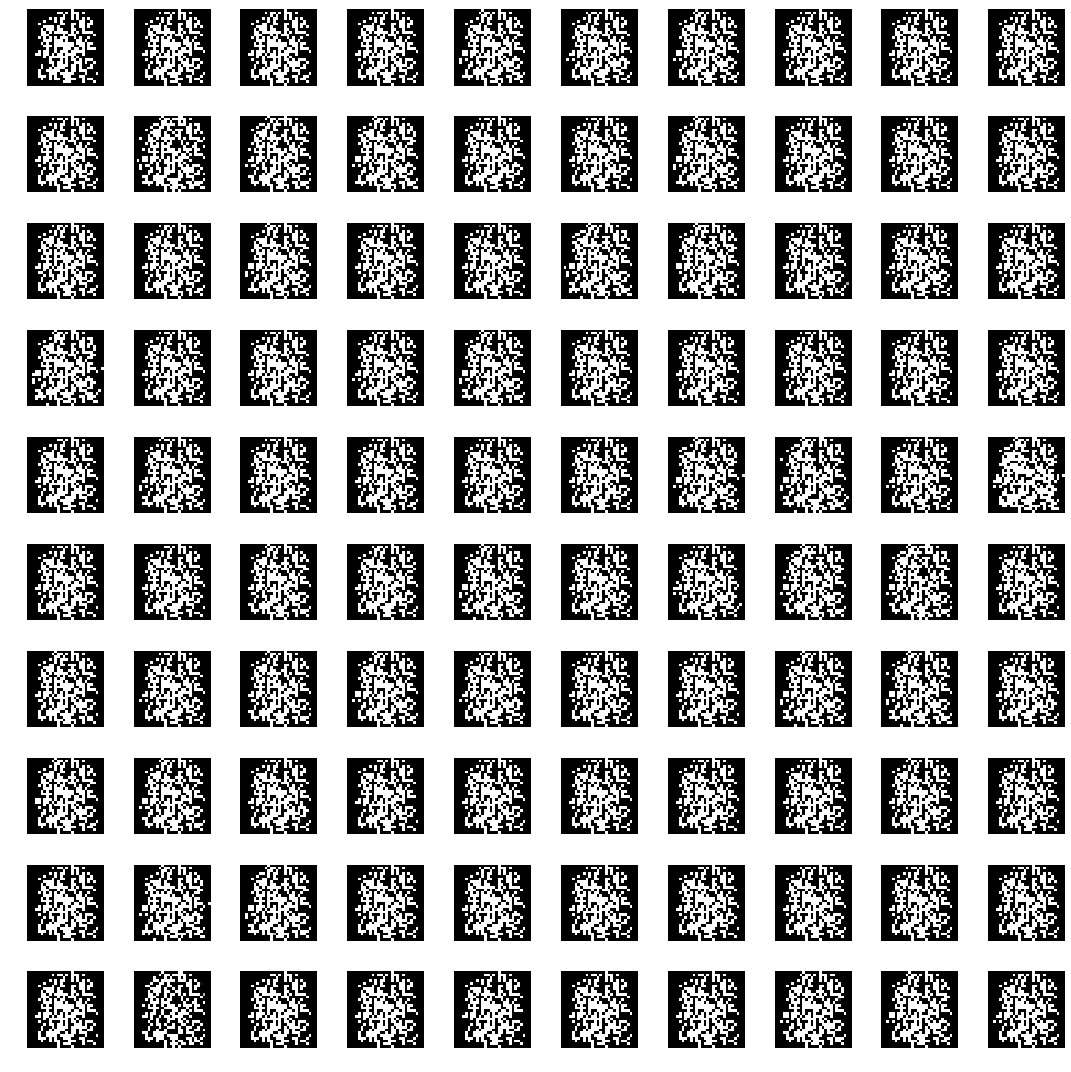

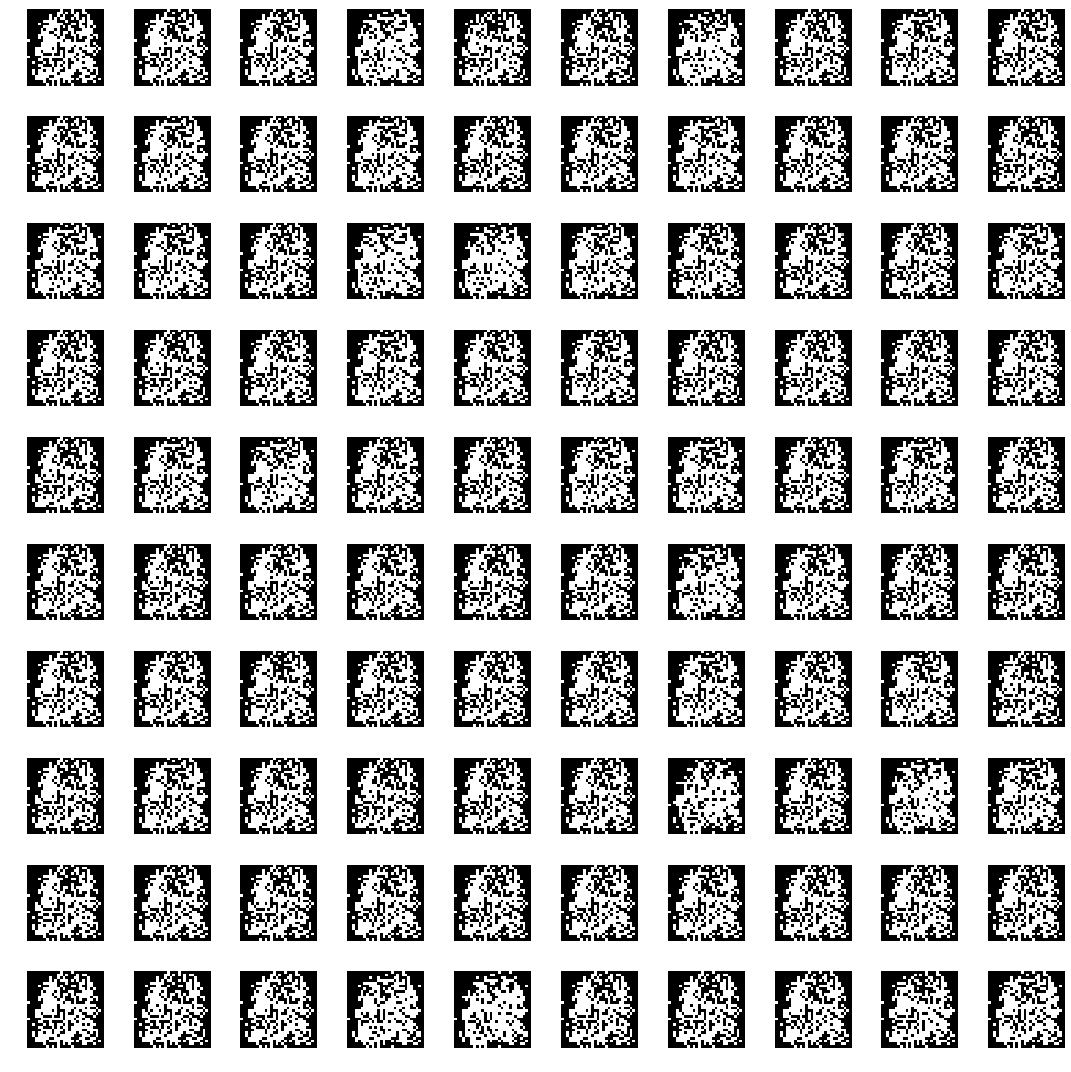

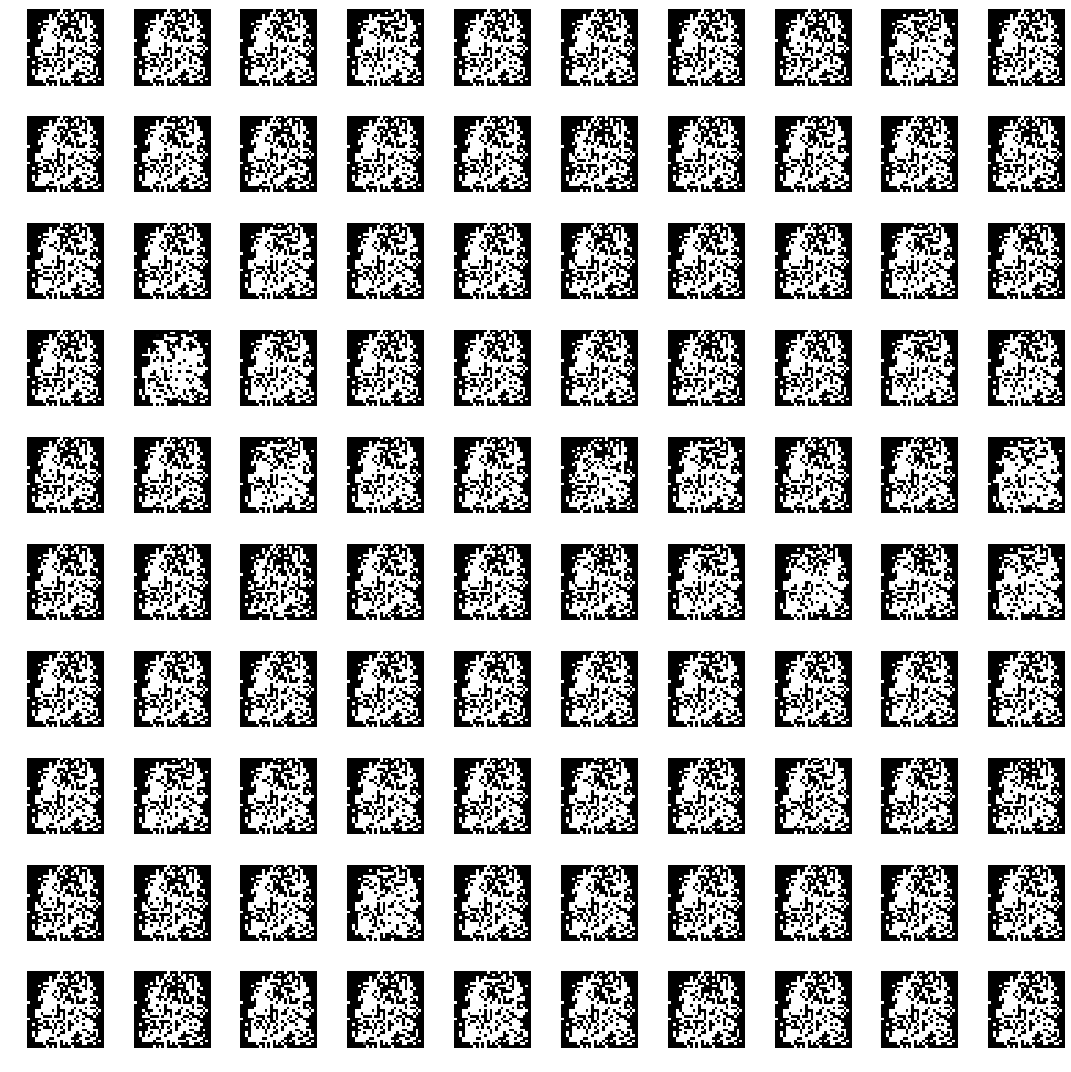

In [45]:
train(X_train,epochs = 50, batch_size = 100)